## **1.Chuẩn bị môi trường và phân tích tổng quát**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
X_mse = pd.read_csv('../csv/X_mse.csv')

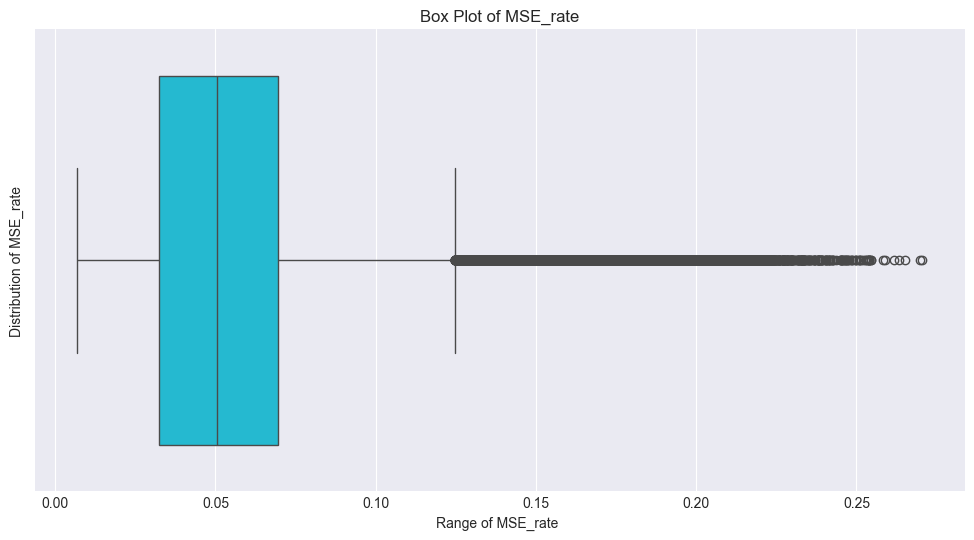

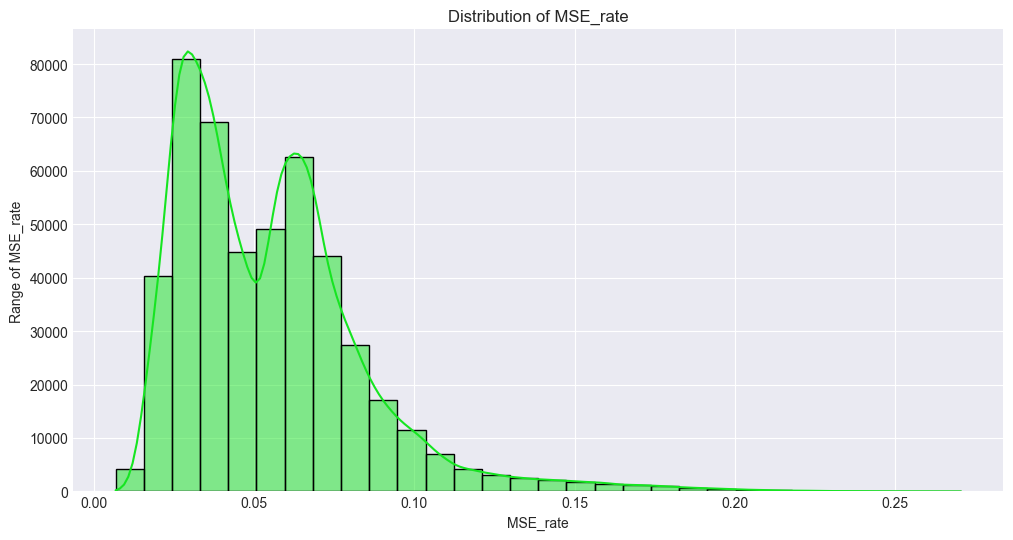

In [3]:
def boxplot_drawing(dataframe: object, 
                    column_name: str) -> object:
    plt.figure(figsize=(12, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.boxplot(x=dataframe[column_name], 
                color= "#09CEEC", 
                log_scale=None)
    plt.title(f'Box Plot of {column_name}')
    plt.xlabel(f'Range of {column_name} ')
    plt.ylabel(f'Distribution of {column_name}')

def histplot_drawing(dataframe: object, 
                     column_name: str) -> object:
    plt.figure(figsize=(12, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.histplot(data=dataframe, 
                 x=column_name, 
                 bins=30, 
                 color="#16E521", 
                 kde=True,
                 log_scale=None)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel(f'Range of {column_name}')
    
boxplot_drawing(X_mse, 'MSE_rate')
histplot_drawing(X_mse, 'MSE_rate')

In [4]:
print(f"Percentage of anomaly from thresholding: {(len(X_mse[X_mse['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)]) / len(X_mse))*100:.2f}%")

Percentage of anomaly from thresholding: 2.00%


In [5]:
len(X_mse[X_mse['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)])

9557

## **2. Áp Dụng Isolation Forest**

### 1. Chuẩn bị dữ liệu

In [6]:
dataset_total_len = len(X_mse)
train_end_idx = int(dataset_total_len * 0.7)
validation_end_idx = int(dataset_total_len * 0.85)

X_train_mse_features = pd.DataFrame(X_mse.iloc[:train_end_idx])
X_validate_mse_features = pd.DataFrame(X_mse.iloc[train_end_idx:validation_end_idx])
X_test_mse_features = pd.DataFrame(X_mse.iloc[validation_end_idx:])

print(f"Training set: {X_train_mse_features.shape}")
print(f"Testing set: {X_validate_mse_features.shape}")
print(f"Validating set: {X_test_mse_features.shape}")

Training set: (334480, 50)
Testing set: (71674, 50)
Validating set: (71675, 50)


- Biểu đồ phân phối MSE rate cho các tập train, validate và test.

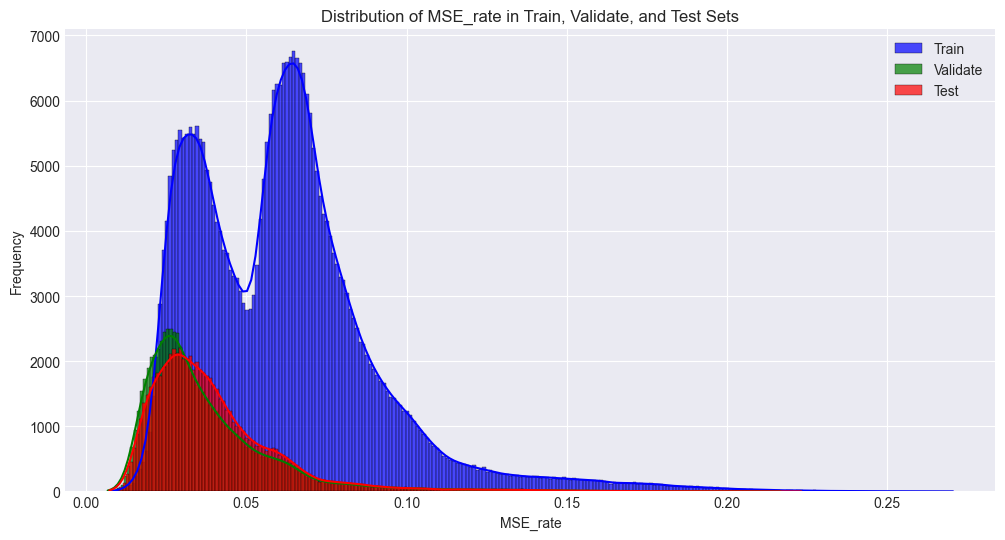

In [94]:
plt.figure(figsize=(12, 6))
sns.histplot(data=X_train_mse_features, 
             x='MSE_rate', 
             color='blue', 
             label='Train', 
             kde=True,
             alpha=0.7)

sns.histplot(data=X_validate_mse_features, 
             x='MSE_rate', 
             color='green', 
             label='Validate', 
             kde=True, 
             alpha=0.7)

sns.histplot(data=X_test_mse_features, 
             x='MSE_rate', 
             color='red', 
             label='Test', 
             kde=True, 
             alpha=0.7)

plt.legend()
plt.title('Distribution of MSE_rate in Train, Validate, and Test Sets')
plt.xlabel('MSE_rate')
plt.ylabel('Frequency');

## **3. Huấn luyện mô hình**

In [8]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(
    n_estimators=700, 
    contamination=0.022, 
    random_state=42
)

isolation_forest.fit(X_train_mse_features)

train_predictions = isolation_forest.predict(X_train_mse_features)
train_anomaly_scores = isolation_forest.decision_function(X_train_mse_features)
train_fraud_labels = (train_predictions == -1).astype(int)

validate_predictions = isolation_forest.predict(X_validate_mse_features)
validate_anomaly_scores = isolation_forest.decision_function(X_validate_mse_features)
validate_fraud_labels = (validate_predictions == -1).astype(int)

## **4. Kiểm thử bằng tập Validate (Hyperparameter tuning)**

In [9]:
forest_results = pd.concat([pd.DataFrame(validate_predictions, columns=['predict']), 
                            pd.DataFrame(validate_anomaly_scores, columns=['anomaly_score']),
                            pd.DataFrame(validate_fraud_labels, columns=['is_fraud'])], axis=1)
comparison_feature = X_validate_mse_features.reset_index(drop=True)
validate_forest = pd.concat([comparison_feature, forest_results], axis=1)
validate_forest['label'] = (validate_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)).astype(int)

print(f"Total anomalies: {len(validate_forest[validate_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)])}")
print(f"Total anomalies predictions made by model: {len(validate_forest.query('is_fraud == 1'))}")
print(f"Actual anomalies correctly identified: {len(validate_forest.query('is_fraud == 1 and MSE_rate > 0.138881922'))}")

Total anomalies: 505
Total anomalies predictions made by model: 3861
Actual anomalies correctly identified: 433


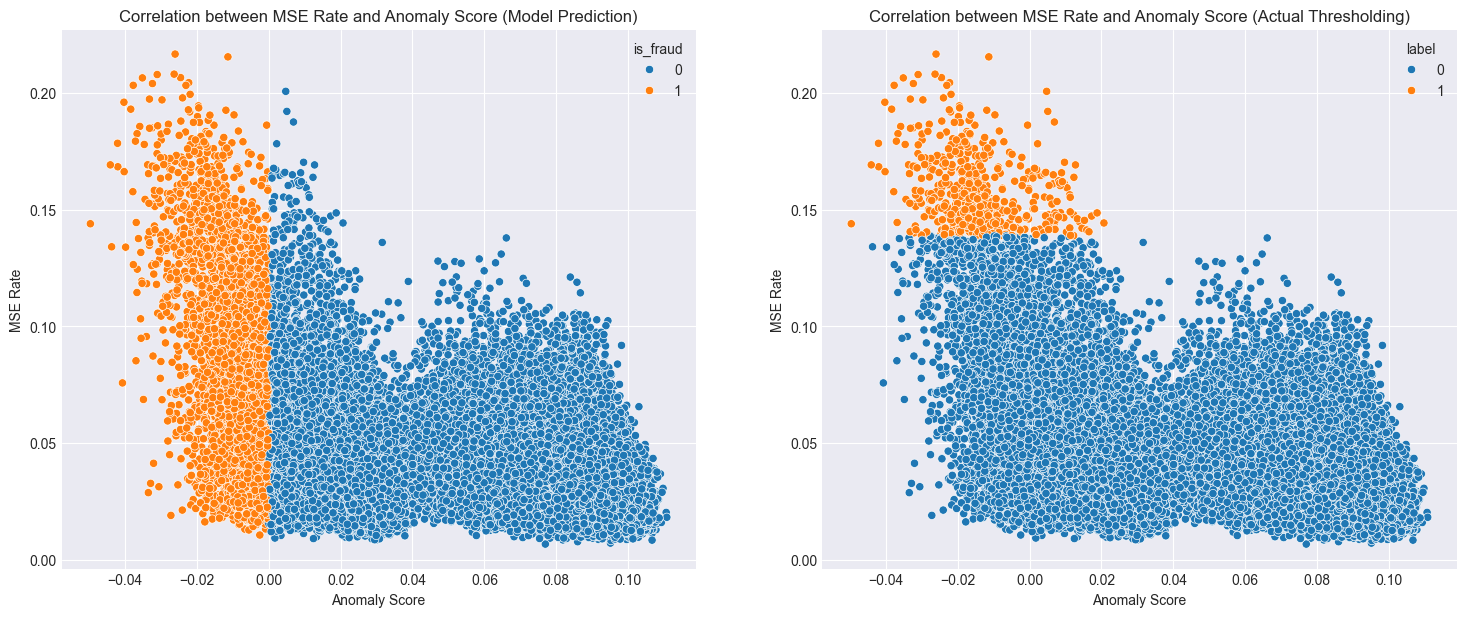

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(data=validate_forest, 
                  x=validate_forest['anomaly_score'],
                  y=validate_forest['MSE_rate'],
                  hue=validate_forest['is_fraud'],
                  ax=ax[0])
ax[0].set(title='Correlation between MSE Rate and Anomaly Score (Model Prediction)',
          xlabel='Anomaly Score',
          ylabel='MSE Rate')

sns.scatterplot(data=validate_forest, 
                  x=validate_forest['anomaly_score'],
                  y=validate_forest['MSE_rate'],
                  hue=validate_forest['label'],
                  ax=ax[1])
ax[1].set(title='Correlation between MSE Rate and Anomaly Score (Actual Thresholding)',
          xlabel='Anomaly Score',
          ylabel='MSE Rate');

## **5. Tái kiểm thử bằng dữ liệu còn lại (tập Test)**

In [11]:
test_predictions = isolation_forest.predict(X_test_mse_features)
test_anomaly_scores = isolation_forest.decision_function(X_test_mse_features)
test_fraud_labels = (test_predictions == -1).astype(int)

forest_results = pd.concat([pd.DataFrame(test_predictions, columns=['predict']), 
                            pd.DataFrame(test_anomaly_scores, columns=['anomaly_score']),
                            pd.DataFrame(test_fraud_labels, columns=['is_fraud'])], axis=1)

comparison_feature = X_test_mse_features.reset_index(drop=True)
test_forest = pd.concat([comparison_feature, forest_results], axis=1)
test_forest['label'] = (test_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)).astype(int)

print(f"Total anomalies: {len(test_forest[test_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)])}")
print(f"Total anomalies predictions made by model: {len(test_forest.query('is_fraud == 1'))}")
print(f"Actual anomalies correctly identified: {len(test_forest.query('is_fraud == 1 and MSE_rate > 0.138881922'))}")

Total anomalies: 475
Total anomalies predictions made by model: 3632
Actual anomalies correctly identified: 394


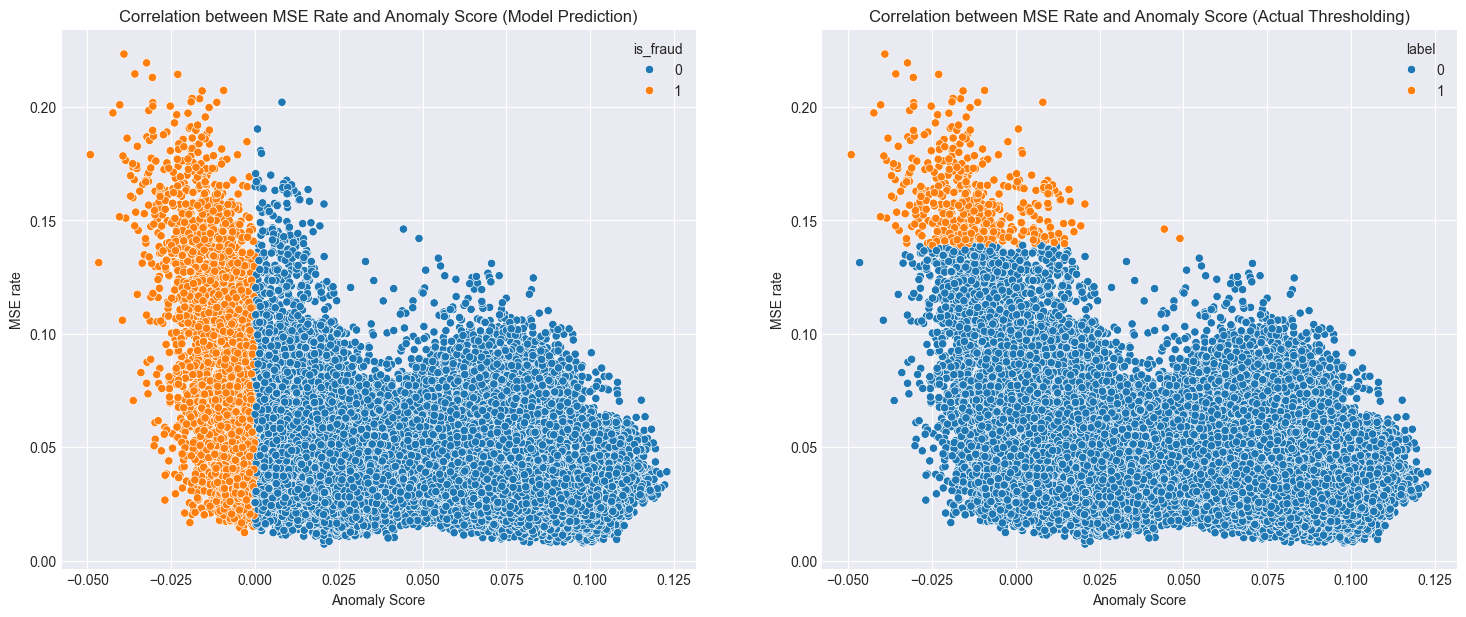

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(data=test_forest,
             x=test_forest['anomaly_score'],
             y=test_forest['MSE_rate'],
             hue=test_forest['is_fraud'],
             ax=ax[0])
ax[0].set(title='Correlation between MSE Rate and Anomaly Score (Model Prediction)',
          xlabel='Anomaly Score',
          ylabel='MSE rate')

sns.scatterplot(data=test_forest,
             x=test_forest['anomaly_score'],
             y=test_forest['MSE_rate'],
             hue=test_forest['label'],
             ax=ax[1])
ax[1].set(title='Correlation between MSE Rate and Anomaly Score (Actual Thresholding)',
          xlabel='Anomaly Score',
          ylabel='MSE rate');

## **6. Tạo Anomaly Score cho toàn tập dữ liệu**

In [13]:
total_predictions = isolation_forest.predict(X_mse)
total_anomaly_scores = isolation_forest.decision_function(X_mse)
total_fraud_labels = (total_predictions == -1).astype(int)

In [14]:
total_forest_results = pd.concat([
    pd.DataFrame(total_predictions, columns=['predict']), 
    pd.DataFrame(total_anomaly_scores, columns=['anomaly_score']),
    pd.DataFrame(total_fraud_labels, columns=['is_fraud'])
], axis=1)

total_comparison_feature = X_mse.reset_index(drop=True)
total_forest = pd.concat([total_comparison_feature, total_forest_results], axis=1)
total_forest['label'] = (total_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.99)).astype(int)

print(f"Total anomalies: {len(total_forest[total_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.99)])}")
print(f"Total anomalies predictions made by model: {len(total_forest.query('is_fraud == 1'))}")
print(f"Actual anomalies correctly identified: {len(total_forest.query('is_fraud == 1 and MSE_rate > 0.16087847079999987'))}")

Total anomalies: 4779
Total anomalies predictions made by model: 14852
Actual anomalies correctly identified: 2855


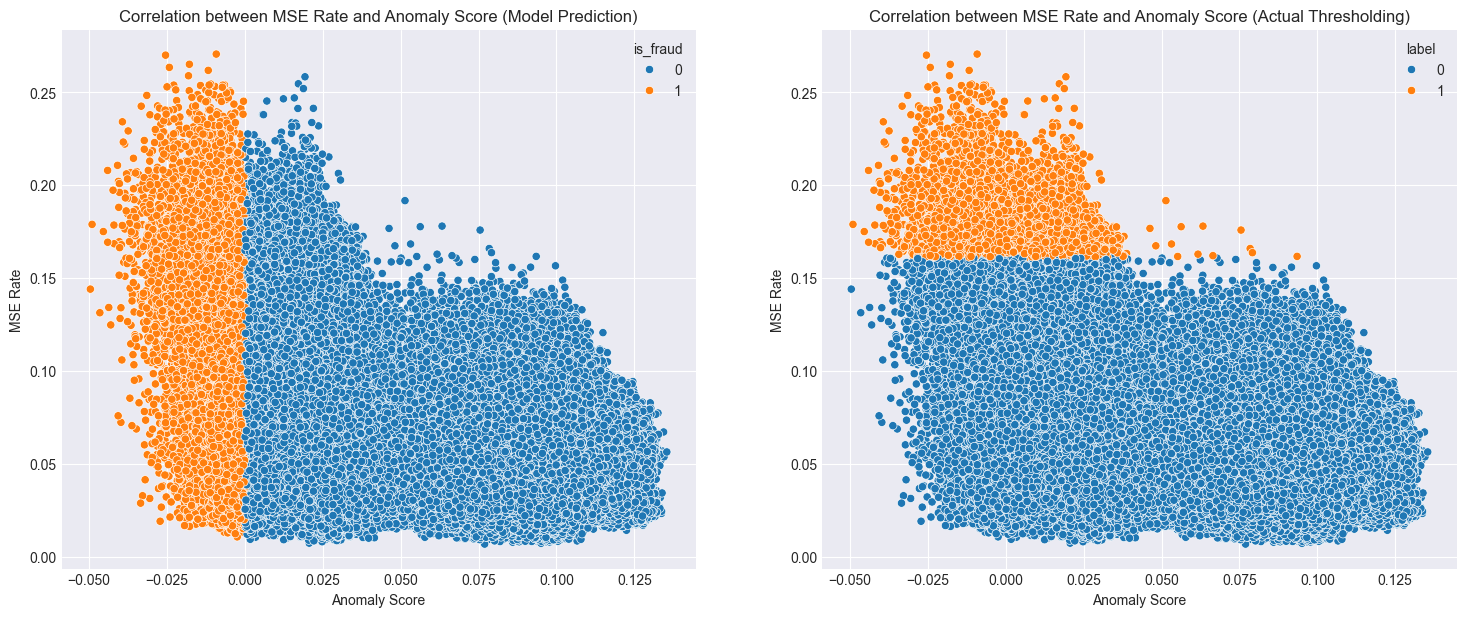

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(data=total_forest,
                x=total_forest['anomaly_score'],
                y=total_forest['MSE_rate'],
                hue=total_forest['is_fraud'],
                ax=ax[0])
ax[0].set(title='Correlation between MSE Rate and Anomaly Score (Model Prediction)',
          xlabel='Anomaly Score',
          ylabel='MSE Rate')

sns.scatterplot(data=total_forest,
                x=total_forest['anomaly_score'],
                y=total_forest['MSE_rate'],
                hue=total_forest['label'],
                ax=ax[1])
ax[1].set(title='Correlation between MSE Rate and Anomaly Score (Actual Thresholding)',
          xlabel='Anomaly Score',
          ylabel='MSE Rate');

## **7. Tạo nhãn**

In [16]:
X_features = pd.concat([X_mse, pd.DataFrame(total_anomaly_scores, columns=['anomaly_score']), pd.DataFrame(total_fraud_labels, columns=['is_fraud'])], axis=1)

In [17]:
X_features['is_fraud'].value_counts()

is_fraud
0    462977
1     14852
Name: count, dtype: int64

In [18]:
# Tính ngưỡng trên TRAIN
mse_thresh = X_train_mse_features["MSE_rate"].quantile(0.99)

In [19]:
score_thresh = X_features["anomaly_score"].quantile(0.98)

In [20]:
dataset_total_len = len(X_features)
train_end_idx = int(dataset_total_len * 0.7)
validation_end_idx = int(dataset_total_len * 0.85)

X_train = pd.DataFrame(X_features.iloc[:train_end_idx])
X_validate = pd.DataFrame(X_features.iloc[train_end_idx:validation_end_idx])
X_test = pd.DataFrame(X_features.iloc[validation_end_idx:])

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_validate.shape}")
print(f"Validating set: {X_test.shape}")

Training set: (334480, 52)
Testing set: (71674, 52)
Validating set: (71675, 52)


In [21]:
# Gán nhãn trên từng tập bằng ngưỡng từ train
def make_labels(df, mse_t=mse_thresh, score_t=score_thresh):
    return (
        (df["MSE_rate"] > mse_t) |
        ((df["is_fraud"] == 1) & (df["anomaly_score"] > score_t))
    ).astype(int)

y_train = make_labels(X_train)
y_valid = make_labels(X_validate)
y_test  = make_labels(X_test)

X_features.drop('is_fraud', axis=1, inplace=True)

## **8. Chạy nhanh XGBoost**

In [22]:
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    confusion_matrix, 
    average_precision_score, 
    classification_report
)

In [23]:
positive = sum(y_train == 1)
negative = sum(y_train == 0)
scale = negative / positive

In [24]:
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=350,
    subsample=0.9,
    scale_pos_weight=scale,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="aucpr"
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [25]:
y_pred_validate = model.predict(X_validate)
y_pred_proba_validate = model.predict_proba(X_validate)[:, 1]

print(f"Accuracy (reference only): {accuracy_score(y_valid, y_pred_validate)}")
print(f"AUC-ROC Score: {roc_auc_score(y_valid, y_pred_proba_validate)}")
print(f"Average Precision Score: {average_precision_score(y_valid, y_pred_proba_validate)}\n")
print("===================== Classification Report =====================\n")
print(classification_report(y_valid, y_pred_validate))
print(f"Confusion Matrix:\n{confusion_matrix(y_valid, y_pred_validate)}")

Accuracy (reference only): 0.9994837737533834
AUC-ROC Score: 0.9999016773288754
Average Precision Score: 0.9422887735937445

===================== Classification Report =====================

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71564
           1       0.75      1.00      0.86       110

    accuracy                           1.00     71674
   macro avg       0.87      1.00      0.93     71674
weighted avg       1.00      1.00      1.00     71674

Confusion Matrix:
[[71527    37]
 [    0   110]]


### 1. Visualization of Validate subset:

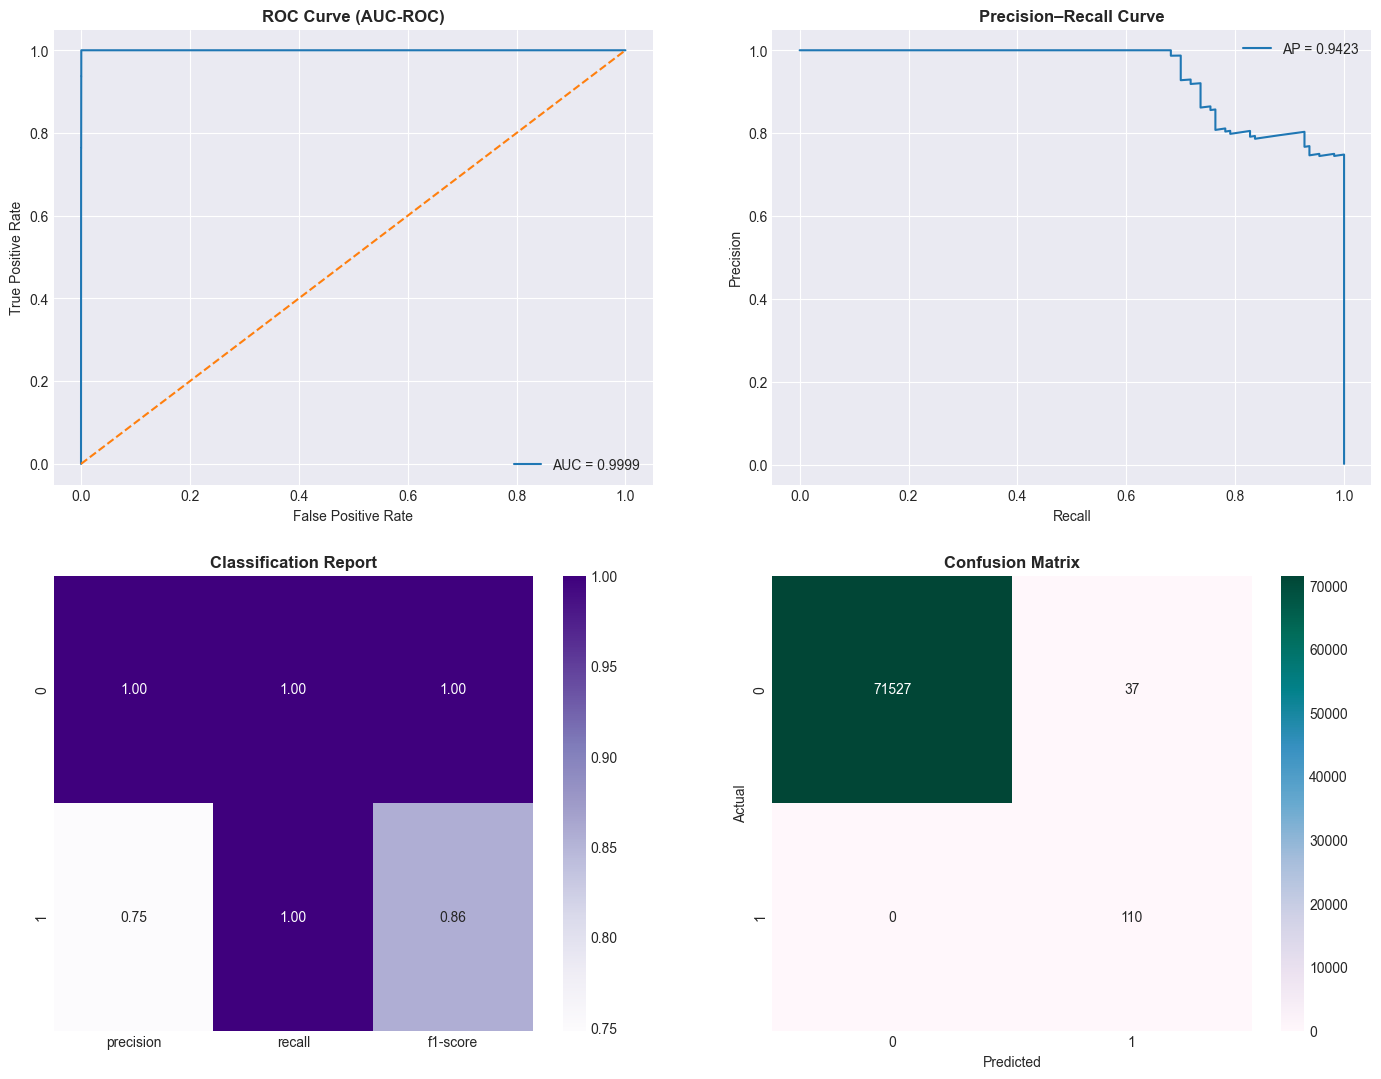

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig, ax =plt.subplots(2,2,figsize=(17,13))

#1. AUC_ROC.
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba_validate)
roc_auc = auc(fpr, tpr)
ax[0,0].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
ax[0,0].plot([0, 1], [0, 1], '--')
ax[0,0].set_title('ROC Curve (AUC-ROC)', fontweight='bold')
ax[0,0].set(xlabel='False Positive Rate',
            ylabel='True Positive Rate')
ax[0,0].legend()

#2. Average Precision.
precision, recall, _ = precision_recall_curve(y_valid, y_pred_proba_validate)
ap = average_precision_score(y_valid, y_pred_proba_validate)
ax[0,1].plot(recall, precision, label=f"AP = {ap:.4f}")
ax[0,1].set_title("Precision–Recall Curve",fontweight='bold')
ax[0,1].set(xlabel='Recall',
            ylabel='Precision')
ax[0,1].legend()

#3. Classification Report.
report = classification_report(y_valid, y_pred_validate, output_dict=True)
df_report = pd.DataFrame(report).transpose()
sns.heatmap(df_report.iloc[:2, :3], annot=True, cmap="Purples", fmt=".2f",ax =ax[1,0])
ax[1,0].set_title('Classification Report',
            fontweight='bold')

#4. Confusion Matrix.
cm = confusion_matrix(y_valid, y_pred_validate)
sns.heatmap(cm, annot=True, fmt="d", cmap="PuBuGn",
            ax=ax[1,1])
ax[1,1].set_title('Confusion Matrix', fontweight='bold')
ax[1,1].set(xlabel='Predicted',
            ylabel='Actual');


In [26]:
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

print(f"Accuracy (reference only): {accuracy_score(y_test, y_pred_test)}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba_test)}")
print(f"Average Precision Score: {average_precision_score(y_test, y_pred_proba_test)}\n")
print("===================== Classification Report =====================\n")
print(classification_report(y_test, y_pred_test))
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_test)}")

Accuracy (reference only): 0.9995395884199512
AUC-ROC Score: 0.9999336963906319
Average Precision Score: 0.9586456859985206

===================== Classification Report =====================

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71569
           1       0.76      1.00      0.87       106

    accuracy                           1.00     71675
   macro avg       0.88      1.00      0.93     71675
weighted avg       1.00      1.00      1.00     71675

Confusion Matrix:
[[71536    33]
 [    0   106]]


### 2. Visualization of Test subset:

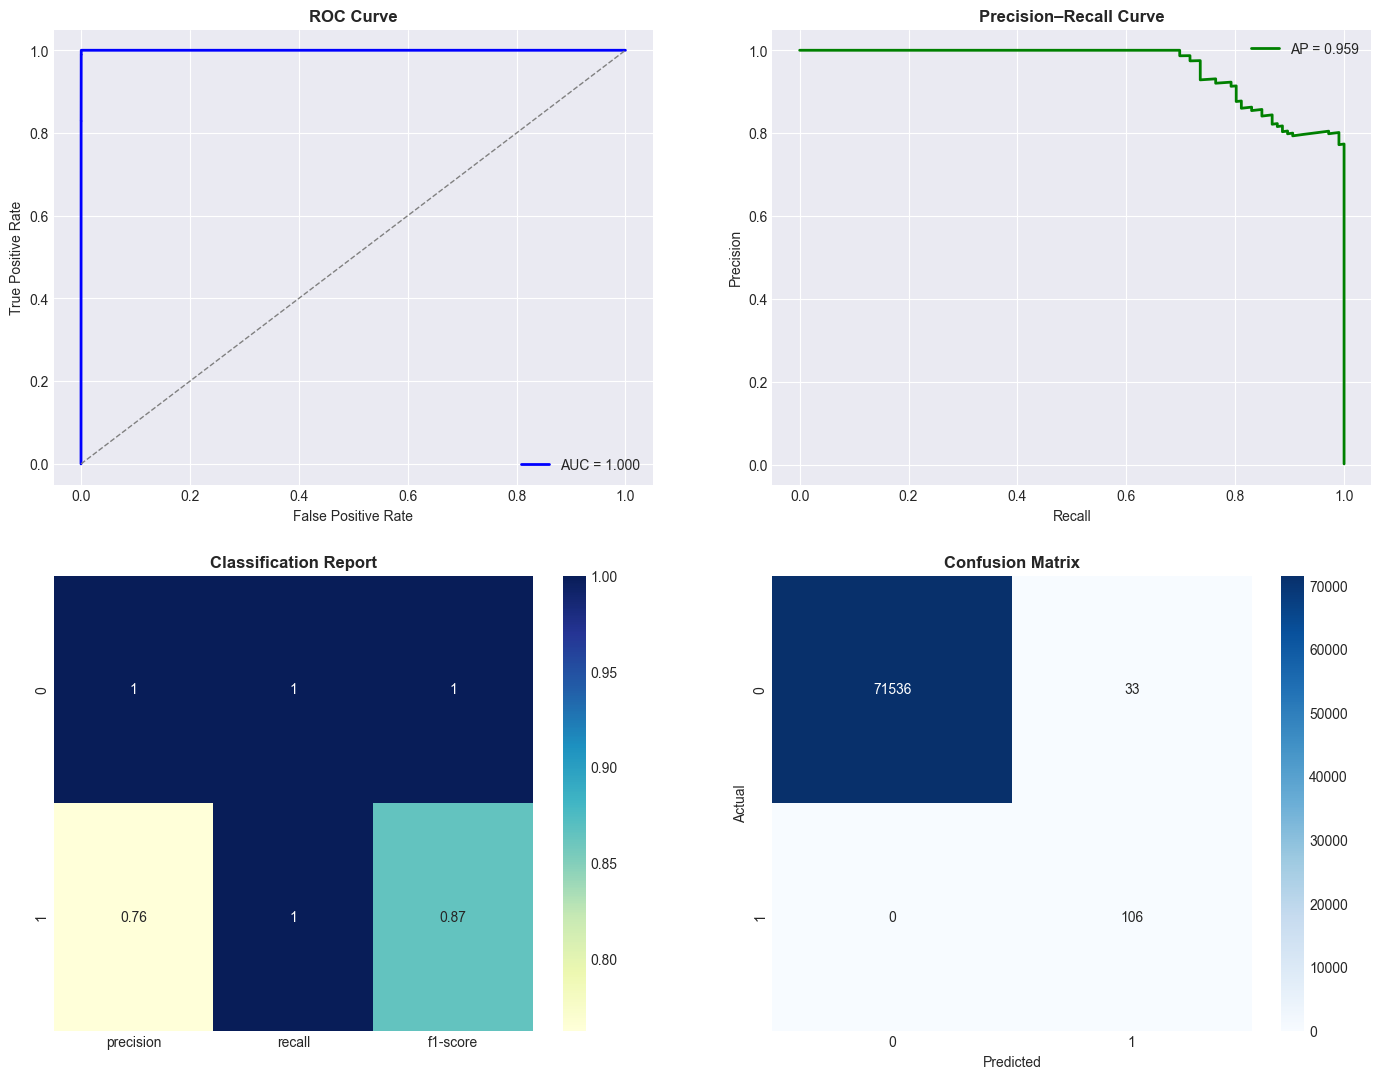

In [93]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig, ax =plt.subplots(2,2,figsize=(17,13))

#1. AUC_ROC.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)
ax[0,0].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
ax[0,0].plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
ax[0,0].set_title('ROC Curve', fontweight='bold')
ax[0,0].set(xlabel='False Positive Rate',
            ylabel='True Positive Rate')
ax[0,0].legend()

#2. Average Precision.
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
avg_precision = average_precision_score(y_test, y_pred_proba_test)
ax[0,1].plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.3f}')
ax[0,1].set_title("Precision–Recall Curve",fontweight='bold')
ax[0,1].set(xlabel='Recall',
            ylabel='Precision')
ax[0,1].legend()

#3. Classification Report.
report = classification_report(y_test, y_pred_test, output_dict=True)
df_report = pd.DataFrame(report).iloc[:-1,:].T
df_report = df_report.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
sns.heatmap(df_report, annot=True, cmap='YlGnBu', cbar=True,ax =ax[1,0])
ax[1,0].set_title('Classification Report',
            fontweight='bold')

#4. Confusion Matrix.
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            ax=ax[1,1])
ax[1,1].set_title('Confusion Matrix', fontweight='bold')
ax[1,1].set(xlabel='Predicted',
            ylabel='Actual');

### 3. Visualization of Feature Importance:

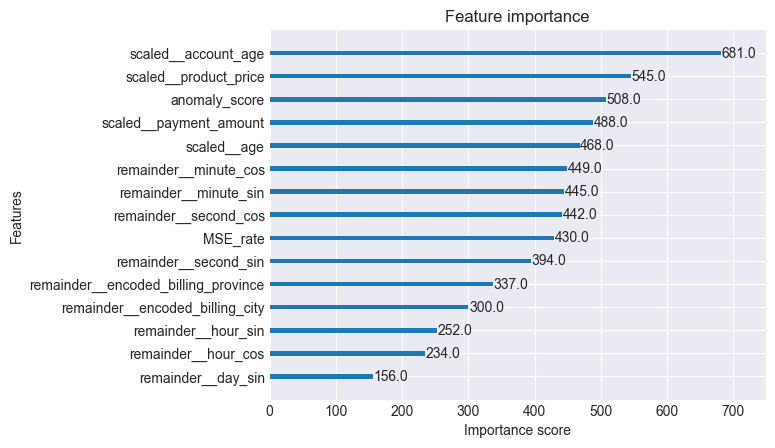

In [27]:
xgb.plot_importance(model, max_num_features=15)
plt.show()